# Apprentissage Supervisé - Régression

*Lorenzo Brucato - Alexandre Loret*
___

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# fonctions pour la regression
from RegFunctions import *

## 1. Visualisation et traitement des données

In [4]:
train = pd.read_parquet("data/train2.parquet") # jeu de données d'entrainement
test = pd.read_parquet("data/test2.parquet")   # jeu de données de prévision

In [5]:
n, p = train.shape
print(n, p) # 100000 données d'entrainement pour 20 variables

100000 22


**Valeurs manquantes :**

In [7]:
print(pd.isna(train).sum().sum())
# pas de valeurs manquantes

print(pd.isna(test).sum().sum())


0
0


*Mais existence de valeurs aberrantes corrigées plus loin*

In [9]:
print(len(train.loc[train['RatecodeID'] == 6.0]))
print(len(test.loc[test['RatecodeID'] == 6.0]))

0
1


RatecodeID ne possède pas de données d'exemples sur la partie train pour la modalité 6.0 (GroupRide). La valeur 6.0 sera attribué pour les valeurs aberrantes et/ou inconnues de la variable 

**Description des variables :**

*Variables explicatives :* 
- `VendorID` : identifiant du fournisseur (1:creative mobile, 2:VeriFone)
- `tpep_pickup_datetime` : date et heure de début de course
- `tpep_dropoff_datetime` : date et heure de fin de course
- `passenger_count` : nombre de passagers de la course
- `trip_distance` : distance de la course
- `PU_location_lat` : latitude (départ)
- `PU_location_lon` : longitude (départ)
- `DO_location_lat` : latitude (arrivée)
- `DO_location_lon` : longitude (arrivée)
- `RatecodeID` : type de tarif (1:standard, 2:JFK, 3:Newark, 4:Nassau or Westchester, 5:Negociated fare, 6:Group ride)
- `store_and_fwd_flag` : données stockées en interne sur le véhicule en cas de non connexion au réseau
- `payment_type` : type de paiement (1:CB, 2:cash, 3:no charge, 4:dispute, 5:inconnu, 6:voided trip)
- `fare_amount` : tarif de la course (dépendance distance + temps)
- `extra` : montant des extras
- `mta_tax` : taxe MTA
- `improvment_surcharge` : taxe additionelle
- `tolls_amount` : montant des péages
- `congestion_surcharge` : taxe additionelle
- `Airport_fee` : frais d'aéroport

*Variable explicative ajoutée : (extraite sur le fichier location.ipynb)*
- `PU_location` : le quartier de new-york de départ ('manhattan', 'bronx', 'queens', 'staten_island', 'airport', 'brooklyn', 'outside')
- `DO_location` : le quartier de new-york d'arrivée ('manhattan', 'bronx', 'queens', 'staten_island', 'airport', 'brooklyn', 'outside')

*Variable cible :*
-  `tip_amount` : montant des pourboires

In [17]:
train.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
count,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.759540,2024-01-17 01:37:59.341700,2024-01-17 01:53:39.024740,1.335090,3.213008,1.998210,1.186610,18.044264,1.538507,0.497315,3.430985,0.525877,0.999882,2.335125,0.140857,40.752187,-73.965628,40.754760,-73.971940
min,1.000000,2023-12-31 23:56:46,2024-01-01 00:03:50,0.000000,0.010000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.576961,-74.174002,40.528686,-74.187679
25%,2.000000,2024-01-09 15:34:38,2024-01-09 15:50:20.750000,1.000000,1.000000,1.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2.000000,2024-01-17 11:32:54.500000,2024-01-17 11:51:50,1.000000,1.690000,1.000000,1.000000,12.800000,1.000000,0.500000,2.800000,0.000000,1.000000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2.000000,2024-01-24 18:09:36,2024-01-24 18:28:48.500000,1.000000,3.100000,1.000000,1.000000,19.800000,2.500000,0.500000,4.200000,0.000000,1.000000,2.500000,0.000000,40.773633,-73.965146,40.773633,-73.961764
max,2.000000,2024-01-31 23:59:07,2024-02-01 10:57:24,7.000000,53.640000,99.000000,4.000000,214.800000,11.750000,0.500000,99.000000,49.260000,1.000000,2.500000,1.750000,40.899528,-73.726655,40.899528,-73.711025
std,0.427365,NaN,NaN,0.847745,4.219928,9.594546,0.458398,15.839824,1.788004,0.036542,3.686474,2.020583,0.009412,0.620490,0.476090,0.032148,0.048564,0.031182,0.036295


**Outliers :**

*Valeurs aberrantes visibles :*

In [21]:
# proportion de valeurs aberrantes sur ratecodeID
print(len(train.loc[train['RatecodeID'] >= 6.0])/len(train))
print(len(test.loc[test['RatecodeID'] >= 6.0])/len(test))

0.00968
0.009918303508385282


 D'après la description on sait que les variables `VendorID`, `RatecodeID`, `store_and_fwd_flag` et `payment_type` sont catégorielles.
 
- pour `payment_type`, les catégories ne vont pas au dela de cinq (pas de données pour les modes de paiements 'inconnu' et 'voided_trip')
- pour `RatecodeID`, des valeurs hors classe atteignent 99.0, la valeur 6.0 n'est visible que sur le jeu de test --> 6.0 devient une catégorie supplémentaire 'inconnue' que l'on supprimera après one hot encoding, pour préserver les features pour lesquelles on a de l'information

In [23]:
test.loc[test['RatecodeID'] >= 6.0, 'RatecodeID']

126        99.0
136        99.0
191        99.0
342        99.0
380        99.0
           ... 
2626867    99.0
2626934    99.0
2626996    99.0
2627036    99.0
2627109    99.0
Name: RatecodeID, Length: 26057, dtype: float64

In [24]:
train.loc[train['RatecodeID'] >= 6.0, 'RatecodeID'] = 6.0
test.loc[test['RatecodeID'] >= 6.0, 'RatecodeID'] = 6.0

*Valeurs extrêmes de tip_amount*

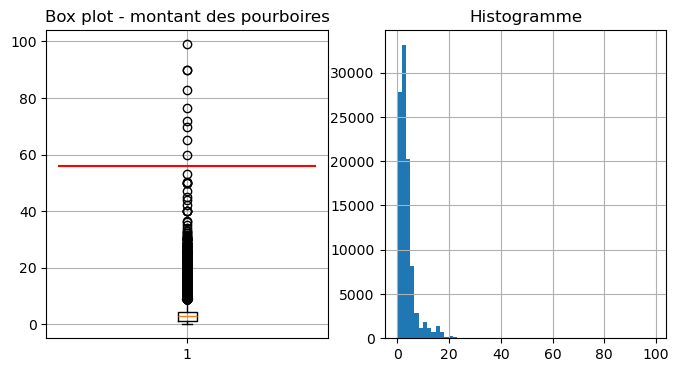

In [29]:
fig, axs=plt.subplots(1, 2, figsize=(8, 4))

axs[0].boxplot(train['tip_amount'])
axs[0].grid()
axs[0].set_title('Box plot - montant des pourboires')
axs[0].plot([0, 2], [56, 56], color='red')

axs[1].hist(train['tip_amount'], bins=60)
axs[1].grid()
axs[1].set_title('Histogramme')

plt.savefig('figs/DistribTips.png')

On note ici la présence de valeurs exceptionelles pour le tip_amount qui sont en très faible nombre en comparaison du nombre de données, qui pourraient biaiser les résultats et qui ont une trop grande influence sur les métriques de score relativement au nombre de données disponibles. On décide de supprimer ces valeurs au dessus de 60, pour ne pas surajuster les modèles en fonction de ces observations :

In [32]:
train = train.drop(train[train['tip_amount'] >= 58].index)

**Ajout d'une variable supplémentaire (voyage intra/inter quartiers) :**

In [35]:
train['same_location'] = 1.0 * (train['DO_location'] == train['PU_location'])
test['same_location'] = 1.0 * (test['DO_location'] == test['PU_location'])

proportions de voyages sur les mêmes quartiers :

Text(0.5, 0.98, 'Intra quarters trips')

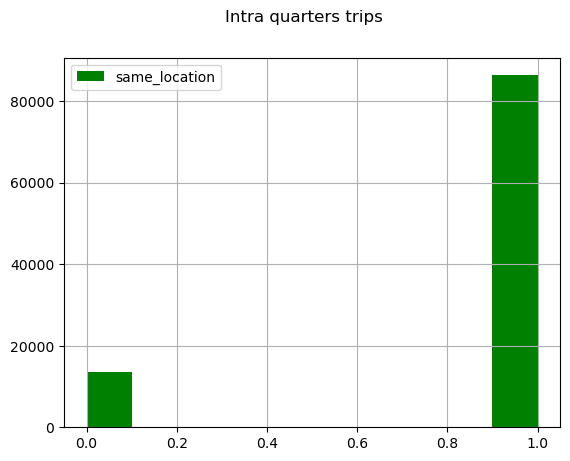

In [38]:
plt.hist(train['same_location'], color='green', label='same_location')
plt.grid()
plt.legend()
plt.suptitle('Intra quarters trips')

**Porportions des voyages dans chaque quartier (départ et arrivée) :**

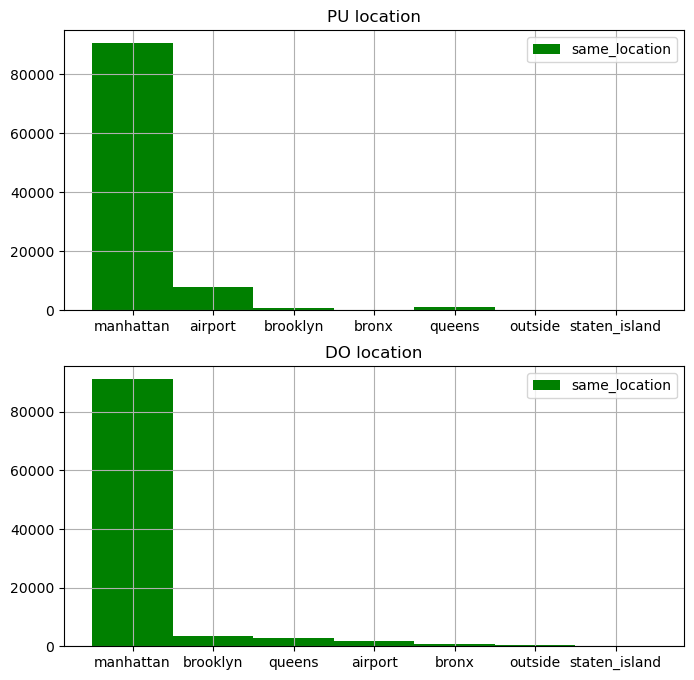

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].hist(train['PU_location'], color='green', label='same_location', bins=[-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
axs[0].grid()
axs[0].legend()
axs[0].set_title('PU location')

axs[1].hist(train['DO_location'], color='green', label='same_location', bins=[-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
axs[1].grid()
axs[1].legend()
axs[1].set_title('DO location')
plt.savefig('figs/histlocation.png')

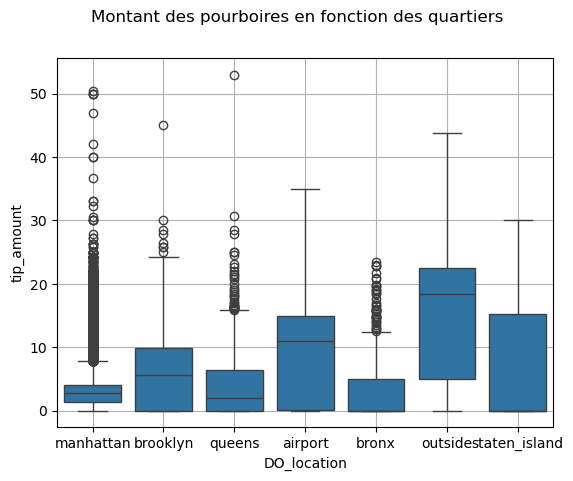

In [42]:
sns.boxplot(x='DO_location', y='tip_amount', data=train)
plt.suptitle('Montant des pourboires en fonction des quartiers')
plt.grid()
plt.savefig('figs/boxplotlocation.png')

On remarque que la grande majorité des courses sont localisées à manhattan. On a également 
une allure différente sur le pourboir conditionellement aux différentes régions.

On transforme les variables catégorielles en vecteurs one-hot (avec suppression de la première colonne pour préserver l'identifiabilité du plan d'expérience) :

In [47]:
classes = train[['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'PU_location', 'DO_location']]
train = pd.get_dummies(train, columns=['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'PU_location', 'DO_location'],  dtype=int)
test = pd.get_dummies(test, columns=['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'PU_location', 'DO_location'], dtype=int)

In [48]:
train.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'same_location', 'VendorID_1', 'VendorID_2',
       'RatecodeID_1.0', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0',
       'RatecodeID_5.0', 'RatecodeID_6.0', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'PU_location_airport',
       'PU_location_bronx', 'PU_location_brooklyn', 'PU_location_manhattan',
       'PU_location_outside', 'PU_location_queens',
       'PU_location_staten_island', 'DO_location_airport', 'DO_location_bronx',
       'DO_location_brooklyn', 'DO_location_manhattan', 'DO_location_outside',
       'DO_location_queens', 'DO_location_staten_island'],
    

*Suppression d'une colonne de chaque classe pour préserver l'identifiabilité :*

In [50]:
train = train.drop(['VendorID_1', 'RatecodeID_6.0', 'store_and_fwd_flag_Y', 'payment_type_4', 'PU_location_outside', 'DO_location_outside'], axis=1)
test = test.drop(['VendorID_1', 'RatecodeID_6.0', 'store_and_fwd_flag_Y', 'payment_type_4', 'PU_location_outside', 'DO_location_outside'], axis=1) 

**calcul de la durée des trajets :**

On récupère la durée en secondes du trajet en faisant la différence des dates fournises (dropoff et pickup) pour créer plusieurs variables sur la durée : 

In [52]:
# durée de trajet
train['duration'] = (pd.to_datetime(train['tpep_dropoff_datetime']) - pd.to_datetime(train['tpep_pickup_datetime'])).dt.seconds
test['duration'] = (pd.to_datetime(test['tpep_dropoff_datetime']) - pd.to_datetime(test['tpep_pickup_datetime'])).dt.seconds

# logarithme de la durée pour éviter l'écrasement des valeurs tip_amount (cf visualisation) et afficher une meilleure corrélation linéaire 
train['log_duration'] = np.log(train['duration'] + 1)
test['log_duration'] = np.log(test['duration'] + 1)

# longs voyages 
train['long_trip'] = 1.0* (train['duration'] > 70000)
test['long_trip'] = 1.0 * (test['duration'] > 70000)

**distance à vol d'oiseau :**

En plus de la distance du trajet, on peut calculer la distance euclidienne du trajet à  partir des positions de départ et d'arrivée /

In [55]:
train['euclidian_distance'] = np.sqrt( (train['DO_location_lon'] - train['PU_location_lon'])**2 + (train['DO_location_lat'] - train['PU_location_lat'])**2 )
test['euclidian_distance'] = np.sqrt( (test['DO_location_lon'] - test['PU_location_lon'])**2 + (test['DO_location_lat'] - test['PU_location_lat'])**2 ) 

**vitesse de course :**

In [57]:
train['speed'] = train['trip_distance']/(train['duration'] + 1e-3) # on s'assure d'avoir une valeur finie
test['speed'] = test['trip_distance']/(test['duration'] + 1e-3)  # on s'assure d'avoir une valeur finie

train['log_speed'] = np.log(train['speed'])  # valeur écrasées sur la gauche --> passage au log
test['log_speed'] = np.log(test['speed'])    

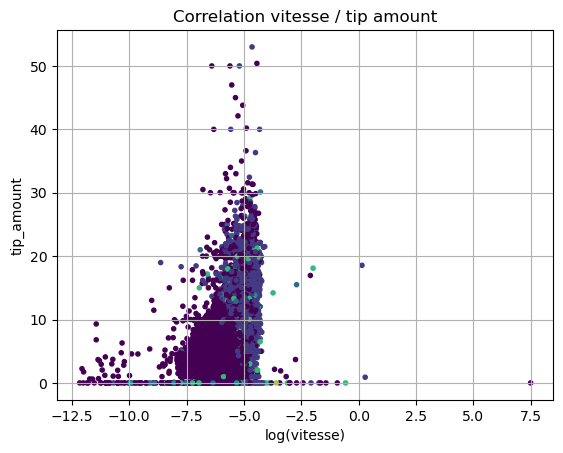

In [58]:
plt.scatter(train['log_speed'], train['tip_amount'], c=pd.factorize(classes['PU_location'])[0], marker='.', label='couleur par location')
plt.title("Correlation vitesse / tip amount")
plt.xlabel("log(vitesse)")
plt.ylabel("tip_amount")
plt.grid()

On fera notamment attention à la correlation forte entre distance du voyage/distance euclidienne  : 

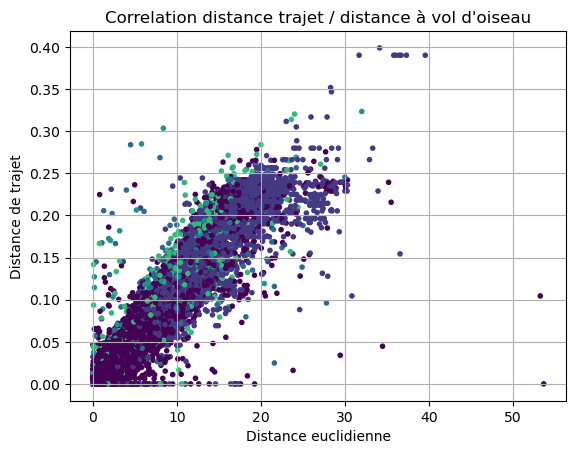

In [60]:
plt.scatter(train['trip_distance'], train['euclidian_distance'],  c=pd.factorize(classes['PU_location'])[0], marker='.', label='couleur par location')
plt.title("Correlation distance trajet / distance à vol d'oiseau")
plt.xlabel("Distance euclidienne")
plt.ylabel("Distance de trajet")
plt.grid()

**pic fixe de fare_amount à 70.0, indépendant de la distance de trajet :**

on remarque également un tarif fixe à 70.0 qui semble sélectionné indépendamment du temps et de la distance de trajet : 

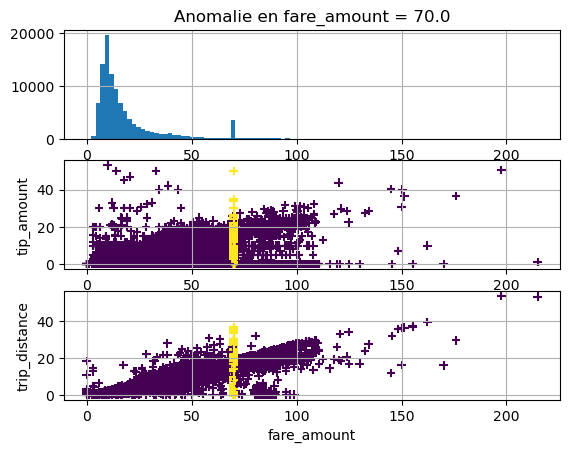

In [69]:
fig, axs = plt.subplots(3, 1)

axs[0].set_title('Anomalie en fare_amount = 70.0')
axs[0].hist(train['fare_amount'], bins=100)
axs[0].grid()

axs[1].scatter(train['fare_amount'], train['tip_amount'], c = (train['fare_amount'] == 70.0), marker='+')
axs[1].set_xlabel('fare_amount')
axs[1].set_ylabel('tip_amount')
axs[1].grid()

axs[2].scatter(train['fare_amount'], train['trip_distance'], c = (train['fare_amount'] == 70.0), marker='+')
axs[2].set_xlabel('fare_amount')
axs[2].set_ylabel('trip_distance')
axs[2].grid()

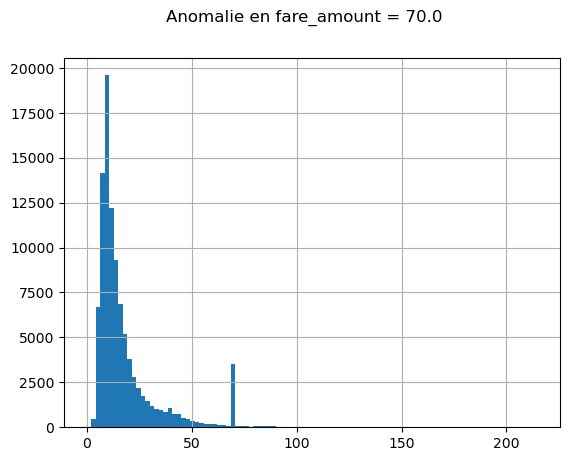

In [70]:
plt.suptitle('Anomalie en fare_amount = 70.0')
plt.hist(train['fare_amount'], bins=100)
plt.grid()

On constate que cette information est hautement corrélée au type de tarif fixe `RatecodeID_2.0` : 4 lignes du jeu de données seulement ou les deux informations ne sont pas similaires :

In [73]:
fix_fare_amount = 1.0 * (train['fare_amount'] == 70.0)
train.loc[train['RatecodeID_2.0'] != fix_fare_amount]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,DO_location_brooklyn,DO_location_manhattan,DO_location_queens,DO_location_staten_island,duration,log_duration,long_trip,euclidian_distance,speed,log_speed
33902,2024-01-16 23:20:11,2024-01-17 00:05:00,1.0,18.69,70.0,0.0,0.5,15.15,0.00,1.0,...,0,1,0,0,2689,7.897296,0.0,0.232393,0.006951,-4.968936
72128,2024-01-17 02:34:45,2024-01-17 02:48:02,1.0,11.01,70.0,0.0,0.0,30.12,13.88,1.0,...,0,0,0,1,797,6.682109,0.0,0.169310,0.013814,-4.282052
72716,2024-01-28 12:03:32,2024-01-28 12:53:14,1.0,18.44,0.0,0.0,0.5,0.00,0.00,1.0,...,0,1,0,0,2982,8.000685,0.0,0.231012,0.006184,-5.085828
84734,2024-01-18 15:46:49,2024-01-18 15:54:08,1.0,0.01,0.0,0.0,0.5,0.00,0.00,1.0,...,0,0,1,0,439,6.086775,0.0,0.032277,0.000023,-10.689672


**Heure d'arrivée :**

In [75]:
train['hour'] = (pd.to_datetime(train['tpep_dropoff_datetime'])).dt.hour + (pd.to_datetime(train['tpep_dropoff_datetime'])).dt.minute / 60
test['hour'] = (pd.to_datetime(test['tpep_dropoff_datetime'])).dt.hour + (pd.to_datetime(test['tpep_dropoff_datetime'])).dt.minute / 60

**Week-end :**

In [78]:
train['week_end'] = (pd.to_datetime(train['tpep_dropoff_datetime'])).apply(lambda x: x.weekday() >= 5).astype(int)
test['week_end'] = (pd.to_datetime(test['tpep_dropoff_datetime'])).apply(lambda x: x.weekday() >= 5).astype(int)

**Jour du mois :**

In [80]:
train['day'] = (pd.to_datetime(train['tpep_dropoff_datetime'])).dt.day
test['day'] = (pd.to_datetime(test['tpep_dropoff_datetime'])).dt.day

**Jours feries :** (1 et 15 janvier 2024 pour l'ensemble des données)

In [82]:
train['ferie'] = 1.0 * ( (train['day'] == 1) | (train['day'] == 15) )
test['ferie'] = 1.0 * ( (test['day'] == 1) | (test['day'] == 15) )

**Matrices de corrélation :**

*Taxes additionelles :*

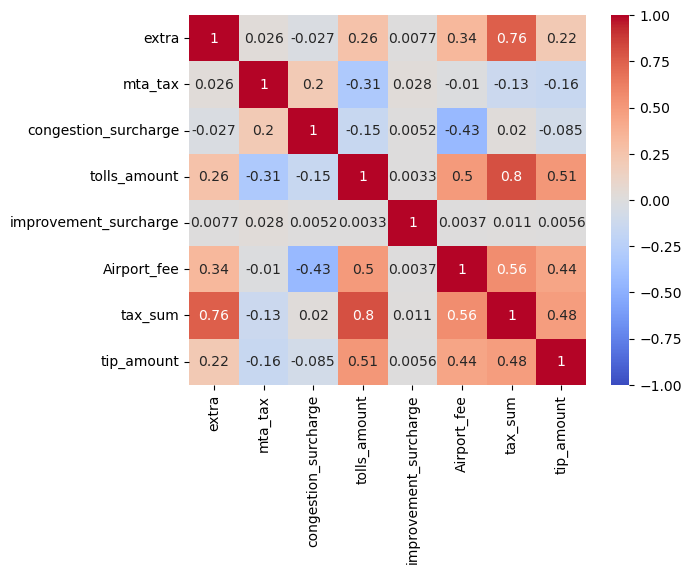

In [89]:
tax_vars = ['extra', 'mta_tax', 'congestion_surcharge', 'tolls_amount', 'improvement_surcharge', 'Airport_fee']
train['tax_sum'] = train[tax_vars].sum(axis=1)
test['tax_sum'] = test[tax_vars].sum(axis=1)
sns.heatmap(train[tax_vars + ['tax_sum', 'tip_amount']].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.savefig('figs/corrtax.png')

C:\Users\User\AppData\Local\Temp\ipykernel_28240\1925135768.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clrmap = plt.cm.get_cmap('viridis',7)


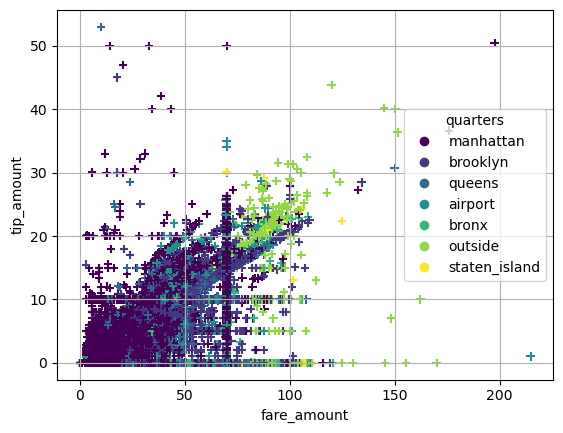

In [94]:
plt.scatter(train['fare_amount'], train['tip_amount'], marker='+', c=pd.factorize(classes['DO_location'])[0])
clrmap = plt.cm.get_cmap('viridis',7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=clrmap(i), markersize=8) for i in range(7)]
plt.xlabel('fare_amount')
plt.ylabel('tip_amount')
plt.grid()
plt.legend(handles, list(pd.factorize(classes['DO_location'])[1]),title='quarters')
plt.savefig('figs/tipfare.png')

*Distances de trajets, durée,  nombre de passagers, dates :*

<Axes: >

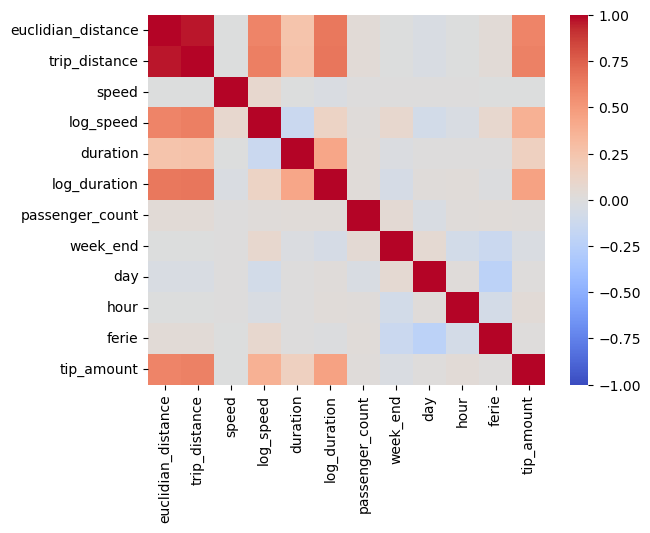

In [81]:
trip_vars = ['euclidian_distance', 'trip_distance', 'speed', 'log_speed', 'duration', 'log_duration', 'passenger_count', 'week_end', 'day', 'hour', 'ferie']
sns.heatmap(train[trip_vars + ['tip_amount']].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)

*Lieux, paiement et dates :*

<Axes: >

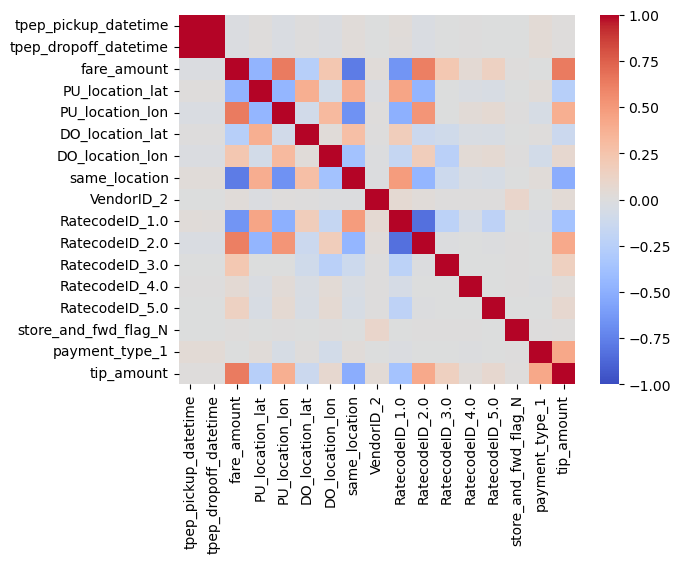

In [83]:
other_vars = [c for c in train.columns if not(c in trip_vars + tax_vars + ['tip_amount'])][:16]
sns.heatmap(train[other_vars + ['tip_amount']].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)

<Axes: >

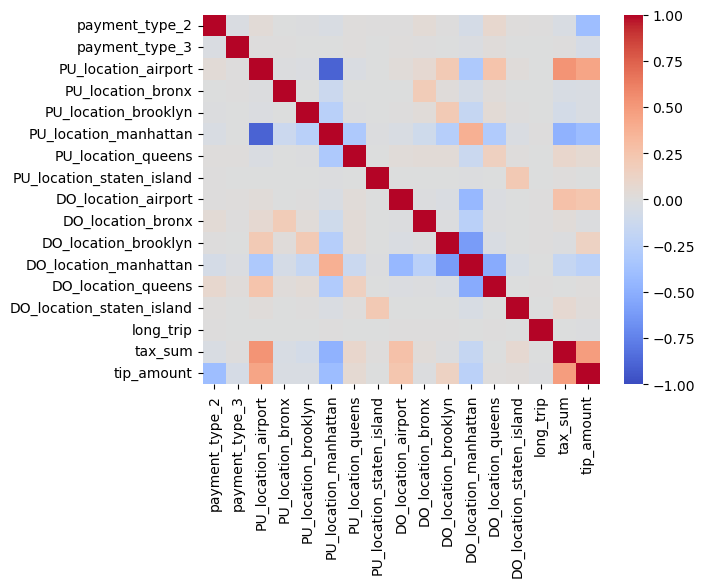

In [84]:
other_vars = [c for c in train.columns if not(c in trip_vars + tax_vars + ['tip_amount'])][16:]
sns.heatmap(train[other_vars + ['tip_amount']].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)

In [85]:
# suppression des variables transformées les moins corrélées et des colonnes inutilisables
train = train.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'speed'], axis=1)
test = test.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'speed'], axis=1)

## 2. Analyse des modèles prédictifs

**Métriques de mesure de performance et recherche d'hyperparamètres par validation croisée :**

In [93]:
# recherche d'hyperparamètres par validation croisée
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_percentage_error
def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'r2': make_scorer(r2_score, greater_is_better=True),
    'rmse': make_scorer(RMSE, greater_is_better=False),
}

**Train, test split et standardisation des données :**

In [96]:
Xtrain, Ytrain = train.drop(['tip_amount'], axis=1), train['tip_amount']
Xtest = test

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

### 2.1 Regression linéaire

In [99]:
from sklearn.linear_model import LinearRegression

In [131]:
LinearModel = LinearRegression()

LM_CV = GridSearchAnalysis(LinearModel,  Xtrain, Ytrain, scoring)

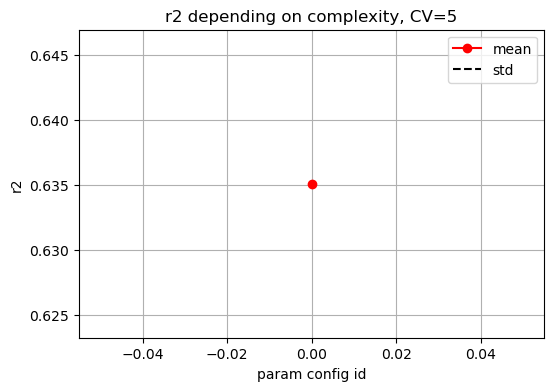

In [133]:
LM_CV.plot_score()

In [135]:
LM_CV.score_table()

,fit_time,r2,rmse
0,0.064 ± 0.004,0.635 ± 0.011,2.184 ± 0.024


### 2.2 Régularisation

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

**Ridge (L2 - réduction des poids) :**

In [ ]:
RidgeModel = Ridge()

param_grid = {
    "alpha":[1e-3, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10]
}

Ridge_CV = GridSearchAnalysis(RidgeModel, Xtrain.drop('same_location', axis=1), Ytrain, scoring, param_grid=param_grid)

In [ ]:
Ridge_CV.plot_score(groupBy='alpha')

In [ ]:
Ridge_CV.score_table()

**Lasso (L1 - sélection de variable) :** 

In [ ]:
LassoModel = Lasso()

param_grid = {
    "alpha":[0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10]
}

Lasso_CV = GridSearchAnalysis(LassoModel, Xtrain, Ytrain, scoring, param_grid=param_grid)

In [ ]:
Lasso_CV.plot_score(groupBy='alpha')

In [ ]:
Lasso_CV.score_table()

L'ajout de régularisation n'a pas grande influence sur la prévision et dégrade la métrique d'évaluation pour des valeurs de paramètres élevés : effet déjà régularisateur du grand nombre de données accessibles.

### 2.3 Modèles additifs + random forest 

(cf regression_gam.R)

### 2.4 Random Forest

*Validation croisée sur l'ensemble des variables :*

In [110]:
#### /!\ Execution longue ####
from sklearn.ensemble import RandomForestRegressor

# exec = True
exec = False

if exec :

    RFModel = RandomForestRegressor()
    
    param_grid = {
        
        'n_estimators': [10],                  # Nombre d'arbres dans la forêt
        'max_depth': [5, 10, 15],              # Profondeur maximale de l'arbre
        'min_samples_split': [50, 100, 500],   # taille minimale de découpage d'un noeud
        'min_samples_leaf': [1, 5, 10, 50],    # taille minimale des feuilles
        'bootstrap':[True]                     # bootstrapping des échantillons 
     
    }
    
    RFModel_CV = GridSearchAnalysis(RFModel, Xtrain, Ytrain, scoring, param_grid=param_grid)
    
else : 
    pass

*Choix du modèle avec les meilleurs performances et le moins de variabilité à priori sur le résultat attendu :*

In [143]:
RFModel = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_split = 100, min_samples_leaf = 5, bootstrap = True)

RFModel.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=100,
                      n_estimators=200)

*Sélection des variables par importance et réévaluation :*
- On supprime euclidian distance qui est moins significative et très corrélée à trip_distance
- On supprime ensuite toutes les catégories avec moins de 1e-3 d'importance
- On conserve les variables qui restent corrélées d'après la matrice de corrélation, en particulier les lieux d'arrivée qui peuvent avoir de la significativité pour des petits groupes de données

In [147]:
importances = RFModel.feature_importances_
feature_names = Xtrain.columns

# Créer un DataFrame pour l'importance des variables
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
2,fare_amount,5.718488e-01
21,payment_type_1,3.400596e-01
15,RatecodeID_1.0,4.388363e-02
44,tax_sum,1.316011e-02
1,trip_distance,4.591838e-03
40,hour,2.715823e-03
12,DO_location_lon,2.637969e-03
4,mta_tax,2.611679e-03
36,log_duration,2.597230e-03
11,DO_location_lat,2.251173e-03


In [161]:
vars = list(feature_importances.loc[feature_importances['importance'] > 1e-5, 'feature'])
sup = ['euclidian_distance', 'same_location', 'congestion_surcharge', 'Airport_fee']
# on supprime euclidian_distance, très corrélé à trip_distance
# on supprime same_location, qui peut être déjà suffisamment représenté par la présence de nombreux lieux de départ et arrivée
# on supprime les taxes moins corrélées, congestion_surcharge, improvement surcharge, déjà prise en partie en compte par tax_sum
vars = [v for v in vars if not(v in sup)]
vars

['fare_amount',
 'payment_type_1',
 'RatecodeID_1.0',
 'tax_sum',
 'trip_distance',
 'hour',
 'DO_location_lon',
 'mta_tax',
 'log_duration',
 'DO_location_lat',
 'day',
 'VendorID_2',
 'PU_location_lat',
 'tolls_amount',
 'log_speed',
 'PU_location_lon',
 'extra',
 'DO_location_bronx',
 'passenger_count',
 'RatecodeID_3.0',
 'DO_location_brooklyn',
 'DO_location_manhattan',
 'week_end',
 'PU_location_queens',
 'ferie',
 'DO_location_airport',
 'DO_location_queens',
 'RatecodeID_5.0',
 'PU_location_brooklyn',
 'PU_location_manhattan',
 'RatecodeID_4.0',
 'PU_location_airport',
 'RatecodeID_2.0']

In [163]:
#### /!\ Execution longue ####
from sklearn.ensemble import RandomForestRegressor

exec = True
#exec = False

if exec :

    RFModel = RandomForestRegressor()
    
    param_grid = {
        
        'n_estimators': [10],                  # Nombre d'arbres dans la forêt
        'max_depth': [5, 10, 15],              # Profondeur maximale de l'arbre
        'min_samples_split': [50, 100, 500],   # taille minimale de découpage d'un noeud
        'min_samples_leaf': [1, 5, 10, 50],    # taille minimale des feuilles
        'bootstrap':[True]                     # bootstrapping des échantillons 
     
    }
    
    RFModel_CV2 = GridSearchAnalysis(RFModel, Xtrain[vars], Ytrain, scoring, param_grid=param_grid)
    
else : 
    pass

*Sélection d'un modèle final :*

In [166]:
RFModel_CV2.score_table()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,bootstrap,fit_time,r2,rmse
0,10,5,50,1,True,1.260 ± 0.030,0.723 ± 0.010,1.893 ± 0.019
1,10,5,100,1,True,1.234 ± 0.027,0.724 ± 0.010,1.890 ± 0.023
2,10,5,500,1,True,1.206 ± 0.013,0.721 ± 0.009,1.901 ± 0.019
3,10,5,50,5,True,1.232 ± 0.041,0.723 ± 0.009,1.895 ± 0.015
4,10,5,100,5,True,1.206 ± 0.015,0.723 ± 0.009,1.893 ± 0.019
5,10,5,500,5,True,1.201 ± 0.008,0.721 ± 0.010,1.901 ± 0.022
6,10,5,50,10,True,1.209 ± 0.015,0.724 ± 0.010,1.891 ± 0.021
7,10,5,100,10,True,1.202 ± 0.013,0.723 ± 0.009,1.894 ± 0.018
8,10,5,500,10,True,1.210 ± 0.017,0.721 ± 0.010,1.902 ± 0.023
9,10,5,50,50,True,1.210 ± 0.008,0.722 ± 0.010,1.896 ± 0.023


### 2.5 XgBoost

*Ensemble des variables, filtrage des données extremes :*

In [215]:
import xgboost as xgb

XGBModel = xgb.XGBRegressor(booster='gbtree')

param_grid = {

    'n_estimators':[50, 100],
    'learning_rate':[0.1, 0.5],
    'max_depth':[3, 5, 7],
    'reg_lambda':[0.0, 1.0, 5.0],
    'reg_alpha':[0.0, 5.0, 50.0, 100.0],

}

XGB_CV = GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [219]:
scores = XGB_CV.score_table()
scores.loc[scores['max_depth'] == 5]

,n_estimators,learning_rate,max_depth,reg_lambda,reg_alpha,fit_time,r2,rmse
24,50,0.1,5,0.0,0.0,0.153 ± 0.006,0.735 ± 0.010,1.852 ± 0.021
25,50,0.1,5,1.0,0.0,0.157 ± 0.011,0.735 ± 0.010,1.853 ± 0.021
26,50,0.1,5,5.0,0.0,0.171 ± 0.015,0.735 ± 0.010,1.852 ± 0.019
27,50,0.1,5,0.0,5.0,0.174 ± 0.014,0.735 ± 0.010,1.852 ± 0.020
28,50,0.1,5,1.0,5.0,0.169 ± 0.015,0.735 ± 0.010,1.852 ± 0.022
29,50,0.1,5,5.0,5.0,0.148 ± 0.003,0.735 ± 0.010,1.853 ± 0.021
30,50,0.1,5,0.0,50.0,0.155 ± 0.008,0.735 ± 0.010,1.852 ± 0.021
31,50,0.1,5,1.0,50.0,0.160 ± 0.014,0.735 ± 0.010,1.851 ± 0.022
32,50,0.1,5,5.0,50.0,0.156 ± 0.017,0.735 ± 0.010,1.852 ± 0.021
33,50,0.1,5,0.0,100.0,0.158 ± 0.015,0.735 ± 0.010,1.854 ± 0.021


Les paramètres de régularisation optimaux permettent ici de limiter le surapprentissage notamment avec `reg_alpha` qui effectue une régularsation L1 pour sélectionner les variables par importance. 

On conserve ici le modèle avec paramètres :
- nombre d'estimateurs = 100
- learning_rate = 0.1
- profondeur maximale des arbres = 5
- paramètre de régularisation L1 = 50.0
- paramètre de régularisation L2 = 1.0

In [222]:
XGBModel = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth =  5, reg_lambda=1.0, reg_alpha=50.0)

XGBModel.fit(scaler.fit_transform(Xtrain), Ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [224]:
importances = XGBModel.feature_importances_
feature_names = Xtrain.columns

# Créer un DataFrame pour l'importance des variables
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

In [226]:
feature_importances

,feature,importance
2,fare_amount,0.334031
21,payment_type_1,0.321522
15,RatecodeID_1.0,0.142685
1,trip_distance,0.072879
44,tax_sum,0.031265
5,tolls_amount,0.019029
4,mta_tax,0.015754
31,DO_location_bronx,0.007238
14,VendorID_2,0.006636
30,DO_location_airport,0.005774


## 3. Soumissions

**1) best_rf : random forest effectuée sur les données originales, première sélection d'hyperparamètres, public score = 0.69302**

In [46]:
from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(n_estimators = 100, max_depth = 10, min_samples_split = 100, bootstrap = True)

best_rf.fit(Xtrain, Ytrain)

Ypred = np.maximum(0.0, best_rf.predict(Xtest)) # prendre une valeur au minimum de zéro (on sait que le montant est positif p.s.)

submit_model('best_rf', Ypred, test)

**2) best_rf2 : random forest effectuée sur les données originales, 2ème sélection d'hyperparamètres, public score = 0.69614**

In [26]:
from sklearn.ensemble import RandomForestRegressor

best_rf2 = RandomForestRegressor(n_estimators = 100, max_depth = 14, min_samples_split = 200, bootstrap = True)

best_rf2.fit(Xtrain, Ytrain)

Ypred = np.maximum(0.0, best_rf2.predict(Xtest))

submit_model('best_rf2', Ypred, test)

**3) GAM + RF : public score = 0.69529**


GAM + RF (réalisée en R)

In [2]:
res_GAMRF = pd.read_parquet("predictions/GAMRF.parquet")  
res_GAMRF

,row_ID,tip_amount
0,1,1.527160
1,2,2.615247
2,3,-0.080727
3,4,2.099159
4,5,0.018646
...,...,...
2627158,2627159,0.061338
2627159,2627160,4.158604
2627160,2627161,2.313959
2627161,2627162,2.998502


In [6]:
submit_model('gamrf_best1', res_GAMRF['tip_amount'], test)

**4) Xgboost regressor, suppresion des valeurs exceptionelles de type amount : public_score = 0.69557** 

In [183]:
import xgboost as xgb

vars = ['payment_type_1',
 'fare_amount',
 'trip_distance',
 'RatecodeID_1.0',
 'tax_sum',
 'mta_tax',
 'tolls_amount',
 'DO_location_airport',
 'VendorID_2',
 'DO_location_bronx',
 'log_duration',
 'DO_location_lon',
 'PU_location_lat',
 'DO_location_lat',
 'extra',
 'hour',
 'DO_location_brooklyn',
 'same_location',
 'PU_location_lon',
 'RatecodeID_4.0',
 'PU_location_airport',
 'RatecodeID_2.0',
 'log_speed',
 'DO_location_manhattan',
 'week_end',
 'RatecodeID_3.0']

xgb_reg = xgb.XGBRegressor(n_estimators = 100, learning_rate=0.1, max_depth = 5, reg_lambda = 5)

xgb_reg.fit(scaler.fit_transform(Xtrain[vars]), Ytrain)

Ypred = np.maximum(0.0, xgb_reg.predict(scaler.transform(Xtest[vars]))) # prendre une valeur au minimum de zéro (on sait que le montant est positif p.s.)

submit_model('xgb_reg2', Ypred, test)

**5) Random forest, suppression de quelques outliers et selection par importance et correlation de variables public_score = 0.69641**

In [231]:
from sklearn.ensemble import RandomForestRegressor

vars = ['fare_amount',
 'payment_type_1',
 'RatecodeID_1.0',
 'tax_sum',
 'trip_distance',
 'DO_location_lat',
 'DO_location_lon',
 'hour',
 'log_duration',
 'extra',
 'VendorID_2',
 'PU_location_lat',
 'tolls_amount',
 'PU_location_lon',
 'DO_location_bronx',
 'RatecodeID_3.0',
 'DO_location_brooklyn',
 'DO_location_airport',
 'DO_location_manhattan',
 'PU_location_brooklyn',
 'DO_location_outside',
 'PU_location_queens',
 'RatecodeID_5.0',
 'same_location',
 'week_end',
 'DO_location_queens',
 'store_and_fwd_flag_N',
 'RatecodeID_4.0',
 'PU_location_airport',
 'Airport_fee',
 'PU_location_manhattan']

RFModel = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_split = 200, bootstrap = True)

RFModel.fit(Xtrain.iloc[outfilters][vars], Ytrain.iloc[outfilters])

Ypred = np.maximum(0.0, RFModel.predict(Xtest[vars]))

submit_model('rf_outfil_impvar', Ypred, test)

NameError: name 'submit' is not defined

**6) Random forest, suppression des valeurs exceptionelles de tip_amount et selection par importance et correlation de variables : public_score = 0.69667**

In [172]:
from sklearn.ensemble import RandomForestRegressor

vars = ['payment_type_1',
 'fare_amount',
 'trip_distance',
 'RatecodeID_1.0',
 'tax_sum',
 'mta_tax',
 'tolls_amount',
 'DO_location_airport',
 'VendorID_2',
 'DO_location_bronx',
 'log_duration',
 'DO_location_lon',
 'PU_location_lat',
 'DO_location_lat',
 'extra',
 'hour',
 'DO_location_brooklyn',
 'same_location',
 'PU_location_lon',
 'RatecodeID_4.0',
 'PU_location_airport',
 'RatecodeID_2.0',
 'log_speed',
 'DO_location_manhattan',
 'week_end',
 'RatecodeID_3.0']

RFModel = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_split = 100, min_samples_leaf=5, bootstrap = True)

RFModel.fit(Xtrain[vars], Ytrain)

Ypred = np.maximum(0.0, RFModel.predict(Xtest[vars]))

submit_model('rf_outfil_impvar2', Ypred, test)

NameError: name 'submit' is not defined

**7) XGBoost, suppression des valeurs exceptionelles de tip amount, régularisation et selection de variable par tuning de paramètres L1/L2 : public score = 0.69840**

In [233]:
xgb_reg = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth =  5, reg_lambda=1.0, reg_alpha=50.0)

xgb_reg.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = np.maximum(0.0, xgb_reg.predict(scaler.transform(Xtest))) # prendre une valeur au minimum de zéro (on sait que le montant est positif p.s.)

submit_model('xgb_reg3', Ypred, test)